In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Function
from torchvision import models, transforms
from make_dloader import make_data
from torch.utils.data import DataLoader
from utils import bbox_collate, MixedRandomSampler
import transform as transf
import yaml
import json
from matplotlib import pyplot as plt
import numbers
import torchvision
import torch.optim as optim
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug import parameters as iap
import time
import random
from model import ResNet50
from cam import Cam

config = yaml.safe_load(open('./config.yaml'))
dataset_means = json.load(open(config['dataset']['mean_file']))

In [2]:
"""class ResNet50(nn.Module):
    def __init__(self, tap = False):
        super().__init__()
        self.num_class = 3 #torose, vascular, ulcer
        self.resnet50 = models.resnet50(pretrained=True)
        self.tap = tap
        self.resnet50.fc =nn.Sequential(nn.Linear(in_features=2048, out_features=self.num_class, bias=True))

    def forward(self,x):
        x = self.resnet50(x)
        return x
    
    def cam(self, x, nwc = False):
        #x 1,2048,512,512
        shape = x.shape[2:] #input shape 512,512
        self.resnet50.eval()
        output = self.resnet50(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        output = np.where(output > 0.5, 1, 0)[0]
        for name, module in self.resnet50._modules.items():
            if name == "avgpool":
                break
            x = module(x)
        maps = []
        for params in self.resnet50.fc.parameters():
            weights = params #3,2048
            break
        x = x[0].data.cpu().numpy() #2048,16,16
        w = weights.data.cpu().numpy() #3,2048
        if nwc:
            w = np.where(w > 0, w, 0)
        w = w[:, :, np.newaxis, np.newaxis]
        for c_id in range(self.num_class):
            if output[c_id] == 0:
                maps.append(0)
                continue
            temp = x*w[c_id] #2048,16,16
            temp = temp.sum(axis=0)
            temp = cv2.resize(temp, shape)
            temp = np.where(temp > 0, temp, 0)
            temp = temp/temp.max()
            
            maps.append(temp)
        return output, maps"""

'class ResNet50(nn.Module):\n    def __init__(self, tap = False):\n        super().__init__()\n        self.num_class = 3 #torose, vascular, ulcer\n        self.resnet50 = models.resnet50(pretrained=True)\n        self.tap = tap\n        self.resnet50.fc =nn.Sequential(nn.Linear(in_features=2048, out_features=self.num_class, bias=True))\n\n    def forward(self,x):\n        x = self.resnet50(x)\n        return x\n    \n    def cam(self, x, nwc = False):\n        #x 1,2048,512,512\n        shape = x.shape[2:] #input shape 512,512\n        self.resnet50.eval()\n        output = self.resnet50(x)\n        output = torch.sigmoid(output)\n        output = output.data.cpu().numpy()\n        output = np.where(output > 0.5, 1, 0)[0]\n        for name, module in self.resnet50._modules.items():\n            if name == "avgpool":\n                break\n            x = module(x)\n        maps = []\n        for params in self.resnet50.fc.parameters():\n            weights = params #3,2048\n         

In [3]:
model = ResNet50()
model.load_state_dict(torch.load("/data/unagi0/masaoka/wsod/model/cam/ResNet50_0.pt"))
model.cuda()

ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [4]:
cam = Cam(model)

In [5]:
a = model.fc_w()

In [6]:
size = config["inputsize"]
val = config["dataset"]["val"]
val.sort()
val = ''.join(map(str,val))
config

{'dataset': {'image_root': '/data/unagi0/masaoka/dataset/capsule/capsule_crop',
  'annotation_file': '/data/unagi0/masaoka/endoscopy/annotations/cleanup0906/capsule_cocoformat.json',
  'split_file': '/data/unagi0/masaoka/endoscopy/annotations/cleanup0906/5-fold.json',
  'mean_file': '/data/unagi0/masaoka/endoscopy/annotations/capsule_mean.json',
  'class_integration': {'new': [{'id': 1, 'name': 'torose lesion'},
    {'id': 2, 'name': 'vascular lesion'},
    {'id': 3, 'name': 'ulcer'}],
   'map': {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 3}},
  'train': [1, 2, 3, 4],
  'val': [0]},
 'negative_ratio': 5,
 'augmentation': {'flip': False,
  'rotate_flip_shear': True,
  'gaussnoise': 1.0,
  'gamma': [0.95, 1.05]},
 'inputsize': 512,
 'n_iteration': 1000,
 'batchsize': 32,
 'learning_rate': 0.0001,
 'warm_up': 200,
 'lr_step': [25000, 40000],
 'weight_decay': 0.0005,
 'save_dir': './result/lr0.0001_ce_bg5_it50000_3class_4_5fold_new',
 'save_freq': 5000}

In [7]:
_, _, _,dataset_val, dataset_all = make_data()
val_anomaly = dataset_val.with_annotation()
#dataset_val = val_anomaly
dataloader_val = DataLoader(dataset_val, num_workers=4, collate_fn=bbox_collate)
unnormalize = transf.UnNormalize(dataset_means['mean'], dataset_means['std'])
normalize = transf.Normalize(dataset_means['mean'], dataset_means['std'])

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!


In [8]:
def heatmap2box(heatmap, img=0, threshold = 0.5):
    # img 512,512,3 ndarray,      heatmap  512,512 ndarray
    if not isinstance(img, numbers.Number):
        image = img.copy()
    heatmap = thresh(heatmap, threshold = threshold)
    heatmap = np.uint8(255*heatmap)
    label = cv2.connectedComponentsWithStats(heatmap)
    n = label[0] - 1
    data = np.delete(label[2], 0, 0)
    boxes = torch.tensor([])
    for i in range(n):
    # 各オブジェクトの外接矩形を赤枠で表示
        x0 = data[i][0]
        y0 = data[i][1]
        x1 = data[i][0] + data[i][2]
        y1 = data[i][1] + data[i][3]
        if boxes.shape[0] == 0:
            boxes = torch.tensor([[x0,y0,x1,y1]])
        else:
            torch.cat((boxes, torch.tensor([[x0,y0,x1,y1]])), dim=0)
        score = threshold
        if not isinstance(img, numbers.Number):
            cv2.rectangle(image, (x0, y0), (x1, y1), (255, 255, 0), thickness = 4)
    if not isinstance(img, numbers.Number):
        plt.imshow(image)
        plt.show()
    return boxes, score
    
def cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * (1-mask)), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img) / 255
    cam = cam / np.max(cam)
    return cam

def thresh(narray, threshold = 0.15, binary = False):
    if binary:
        return np.where(narray>threshold*np.max(narray), 1, 0)
    return np.where(narray>threshold*np.max(narray), narray, 0)

In [9]:
def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

----------------------------------------
Normal
----------------------------------------
torose lesion
----------------------------------------
Normal
----------------------------------------
torose lesion
----------------------------------------
Normal
----------------------------------------
torose lesion
----------------------------------------
Normal
----------------------------------------
torose lesion
----------------------------------------
Normal
----------------------------------------
torose lesion
----------------------------------------
Normal
----------------------------------------
torose lesion
----------------------------------------
Normal
----------------------------------------
torose lesion
----------------------------------------
Normal
----------------------------------------
torose lesion
----------------------------------------
Normal
----------------------------------------
torose lesion
----------------------------------------
Normal
-------------------------

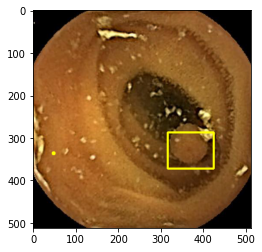

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


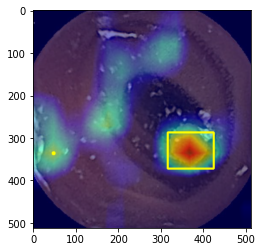

----------------------------------------
torose lesion


TypeError: 'numpy.ndarray' object is not callable

In [10]:
#通常の評価　マスクなし
threshold = .5
gt, tpa, fpa, tna = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
for idx, data in enumerate(dataloader_val): 
    img = data["img"].clone()
    print(f'{idx}/{len(dataloader_val)}', end = '\r')
    
    output, masks = cam(img.cuda().float())
    target = np.zeros(3)
    if len(data["bboxes"][0]) != 0:
        target[int(data["labels"][0][0])] = 1
    
    gt += target
    tp = (output * target)
    fp = (output * (1 - target))
    tn=(1-output)*(1-target)
    tpa += tp
    fpa += fp
    tna += tn
    
    img = unnormalize(data)['img'].copy() 
    img[img<0] = 0
    img[img>255] = 255
    flag = 0
    for num, mask in enumerate(masks):
        if isinstance(mask,numbers.Number):
            flag += 1
            if flag == 3:
                print("----------------------------------------")
                print("Normal")
            continue
        print("----------------------------------------")
        print("CAM")
        if num == 0:
            print("torose lesion")
        elif num == 1:
            print("vascular lesion")
        elif num == 2:
            print("ulcer")
        #mask 512,512
        print(mask.shape)
        
        heatmap2box(mask, img=img, threshold = threshold)
        cam = cam_on_image(img, mask)
        heatmap2box(mask, img=cam, threshold = threshold)
        
    print("----------------------------------------")
    label = 3
    for i in range(len(data["bboxes"][0])):
        x1 = int(data["bboxes"][0][i][0])
        y1 = int(data["bboxes"][0][i][1])
        x2 = int(data["bboxes"][0][i][2])
        y2 = int(data["bboxes"][0][i][3])
        label_name = dataset_val.labels[int(data["labels"][0][i])]
        draw_caption(img, (x1, y1, x2, y2), label_name)
        if label_name == "ulcer":
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255,0, 0), thickness=2) #緑
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2) #赤
        label = int(data["labels"][0][i])
        print(label_name)

    #plt.imshow(img)
    #plt.show()
    
    
    

In [37]:
print(tpa, tna, fpa, gt)

[776.  60.  74.] [5000. 6869. 6968.] [1065.  103.    3.] [982.  75.  76.]


In [31]:
model = models.resnet50(pretrained=True)

In [32]:
for name, module in model._modules.items():
    print(name)
    print(module)

conv1
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu
ReLU(inplace=True)
maxpool
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05

In [6]:
for n, p in model.named_parameters():
    print(n)
    if n == 'model.fc.0.weight':
        print(p)

model.conv1.weight
model.bn1.weight
model.bn1.bias
model.layer1.0.conv1.weight
model.layer1.0.bn1.weight
model.layer1.0.bn1.bias
model.layer1.0.conv2.weight
model.layer1.0.bn2.weight
model.layer1.0.bn2.bias
model.layer1.0.conv3.weight
model.layer1.0.bn3.weight
model.layer1.0.bn3.bias
model.layer1.0.downsample.0.weight
model.layer1.0.downsample.1.weight
model.layer1.0.downsample.1.bias
model.layer1.1.conv1.weight
model.layer1.1.bn1.weight
model.layer1.1.bn1.bias
model.layer1.1.conv2.weight
model.layer1.1.bn2.weight
model.layer1.1.bn2.bias
model.layer1.1.conv3.weight
model.layer1.1.bn3.weight
model.layer1.1.bn3.bias
model.layer1.2.conv1.weight
model.layer1.2.bn1.weight
model.layer1.2.bn1.bias
model.layer1.2.conv2.weight
model.layer1.2.bn2.weight
model.layer1.2.bn2.bias
model.layer1.2.conv3.weight
model.layer1.2.bn3.weight
model.layer1.2.bn3.bias
model.layer2.0.conv1.weight
model.layer2.0.bn1.weight
model.layer2.0.bn1.bias
model.layer2.0.conv2.weight
model.layer2.0.bn2.weight
model.layer2

In [13]:
for n, m in model.named_modules():
    print(n)


model
model.conv1
model.bn1
model.relu
model.maxpool
model.layer1
model.layer1.0
model.layer1.0.conv1
model.layer1.0.bn1
model.layer1.0.conv2
model.layer1.0.bn2
model.layer1.0.conv3
model.layer1.0.bn3
model.layer1.0.relu
model.layer1.0.downsample
model.layer1.0.downsample.0
model.layer1.0.downsample.1
model.layer1.1
model.layer1.1.conv1
model.layer1.1.bn1
model.layer1.1.conv2
model.layer1.1.bn2
model.layer1.1.conv3
model.layer1.1.bn3
model.layer1.1.relu
model.layer1.2
model.layer1.2.conv1
model.layer1.2.bn1
model.layer1.2.conv2
model.layer1.2.bn2
model.layer1.2.conv3
model.layer1.2.bn3
model.layer1.2.relu
model.layer2
model.layer2.0
model.layer2.0.conv1
model.layer2.0.bn1
model.layer2.0.conv2
model.layer2.0.bn2
model.layer2.0.conv3
model.layer2.0.bn3
model.layer2.0.relu
model.layer2.0.downsample
model.layer2.0.downsample.0
model.layer2.0.downsample.1
model.layer2.1
model.layer2.1.conv1
model.layer2.1.bn1
model.layer2.1.conv2
model.layer2.1.bn2
model.layer2.1.conv3
model.layer2.1.bn3
m

In [15]:
for n, m in model.named_children():
    print(n)
    print('00000000000')
    print(m)

model
00000000000
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(